In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

GPUs = tf.config.list_physical_devices('GPU')
print(f"TensorFlow Version: {tf.__version__}")
print("GPU Available:", GPUs)

if not GPUs:
    print("Warning: No GPUs are available! We'll use the CPU")
else:
    print(f"We'll use {GPUs[0]} to make the trainings faster")

TensorFlow Version: 2.20.0
GPU Available: []


In [9]:
# Configuration
DATA_DIR = '../data/raw'
BATCH_SIZE = 32
IMG_HEIGHT = 256
IMG_WIDTH = 256
CLASSES = ['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']

print(f"Data Directory set to: {DATA_DIR}")

Data Directory set to: ../data/raw


Class 'adenocarcinoma': 5000 images
Class 'benign': 5000 images
Class 'squamous_cell_carcinoma': 5000 images
The dataset is balanced


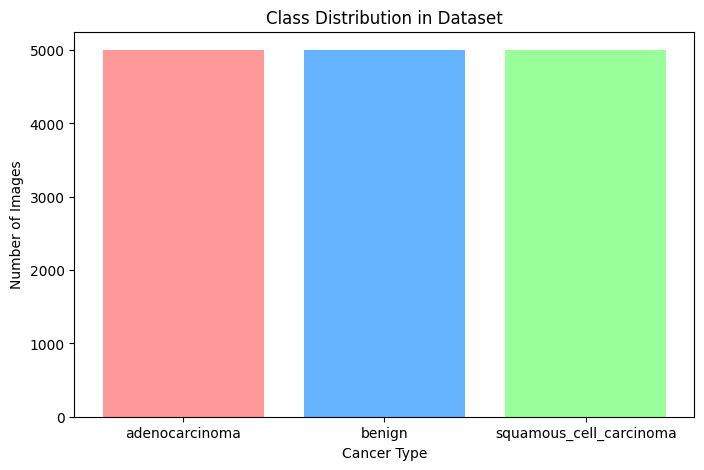

In [19]:
# 3. Analysis & Exploration: Class Distribution
class_counts = {}

for class_name in CLASSES:
    class_path = os.path.join(DATA_DIR, class_name)
    if os.path.exists(class_path):
        count = len(os.listdir(class_path))
        class_counts[class_name] = count
        print(f"Class '{class_name}': {count} images")
    else:
        print(f"Warning: Directory for '{class_name}' not found!")
        break

max_count = max(class_counts.values())
min_count = min(class_counts.values())
if max_count - min_count == 0:
    print("The dataset is balanced")
else:
    print("The dataset is imbalanced")
        
# Visualize the distribution
plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color=['#ff9999','#66b3ff','#99ff99'])
plt.title('Class Distribution in Dataset')
plt.xlabel('Cancer Type')
plt.ylabel('Number of Images')
plt.show()

Displaying random samples from each class...


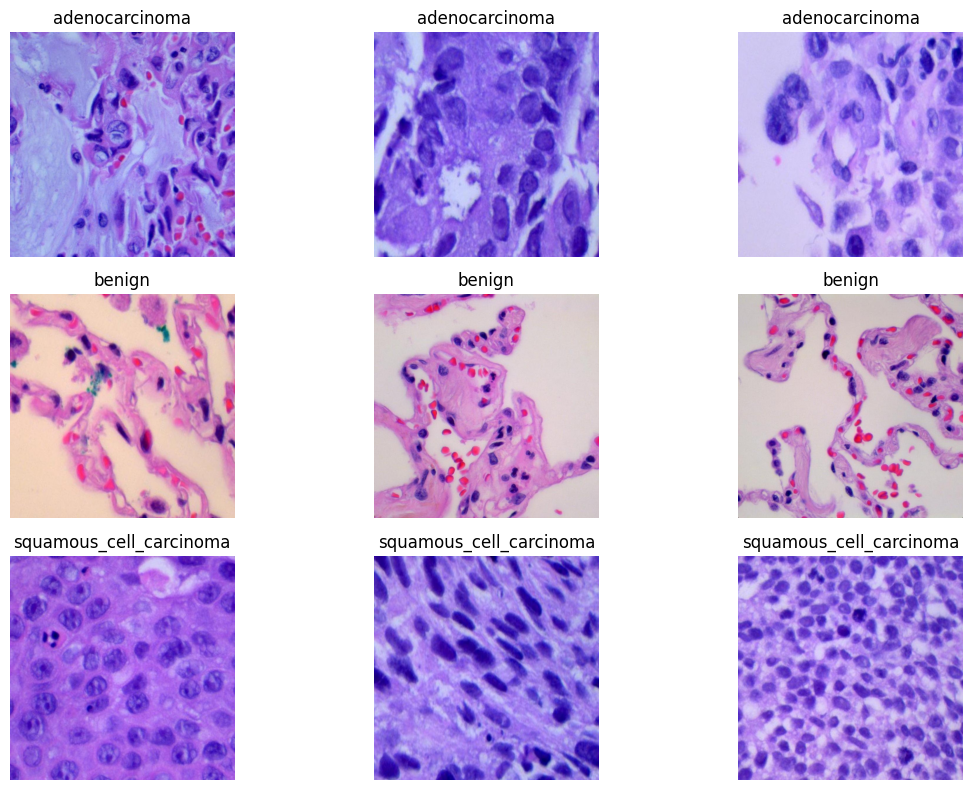

In [61]:
def plot_samples(data_dir, classes, samples_per_class=3):
    plt.figure(figsize=(12, 8))
    
    for i, class_name in enumerate(classes):
        class_path = os.path.join(data_dir, class_name)
        images = np.random.choice(os.listdir(class_path), samples_per_class, replace=False)
        
        for j, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            img = plt.imread(img_path)
            
            plt.subplot(len(classes), samples_per_class, i * samples_per_class + j + 1)
            plt.imshow(img, cmap='gray')
            plt.title(class_name)
            plt.axis('off')
            
    plt.tight_layout()
    plt.show()

print("Displaying random samples from each class...")
plot_samples(DATA_DIR, CLASSES)

In [ ]:
## 4. Data Augmentation (Baseline Strategy)
**Strategy for Version 1.0:**
To establish a valid performance baseline, we will **not** apply any geometric transformations (rotation, zoom, shear) at this stage. 

* **Rescaling:** We will only apply pixel normalization (rescaling pixel values from 0-255 to 0-1) to ensure faster convergence.
* **Validation Split:** We will reserve 20% of the data for validation to monitor for overfitting.

## 5. Model Draft (Initial Architecture)
We construct a sequential Convolutional Neural Network (CNN). The architecture is designed to capture hierarchical features:
1.  **Conv2D Layers:** To detect edges, textures, and shapes.
2.  **MaxPooling2D:** To reduce spatial dimensions and computation.
3.  **Flatten:** To convert 2D feature maps into a 1D vector.
4.  **Dense:** Fully connected layers for classification.

In [23]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 20% for test, 80% for train
)

print("Loading Training Data:")
train_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=42,
    shuffle=True
)

print("\nLoading Validation Data:")
val_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=42,
    shuffle=False
)

print(f"\nClass Indices: {train_generator.class_indices}")

Loading Training Data:
Found 12000 images belonging to 3 classes.

Loading Validation Data:
Found 3000 images belonging to 3 classes.

Class Indices: {'adenocarcinoma': 0, 'benign': 1, 'squamous_cell_carcinoma': 2}


In [26]:
# 1st attempt: using sequential model awith 3 layers of Convolution2D + MaxPooling2D each, with only 10 epoches
model = Sequential([
    # Input Layer
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    
    # Layer 1
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    # Layer 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    # Layer 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    
    # Output Layer (3 neurons for 3 classes, Softmax for probability distribution)
    Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,870,979 (64.36 MB)

 Trainable params: 16,870,979 (64.36 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1
)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 496s 1s/step - accuracy: 0.8410 - loss: 0.3856 - val_accuracy: 0.9223 - val_loss: 0.2114
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 386s 1s/step - accuracy: 0.9227 - loss: 0.1926 - val_accuracy: 0.9360 - val_loss: 0.1651
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 413s 1s/step - accuracy: 0.9305 - loss: 0.1762 - val_accuracy: 0.9230 - val_loss: 0.2049
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 391s 1s/step - accuracy: 0.9495 - loss: 0.1307 - val_accuracy: 0.9467 - val_loss: 0.1434
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 396s 1s/step - accuracy: 0.9668 - loss: 0.0927 - val_accuracy: 0.9283 - val_loss: 0.2001
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.9823 - loss: 0.0517 - val_accuracy: 0.9477 - val_loss: 0.1491
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 381s 1s/step - accuracy: 0.9812 - loss: 0.0502 - val_accuracy: 0.9493 - val_loss: 0.1741
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 378s 1s/step - accuracy: 0.9854 - loss: 0.0446 - val_accu

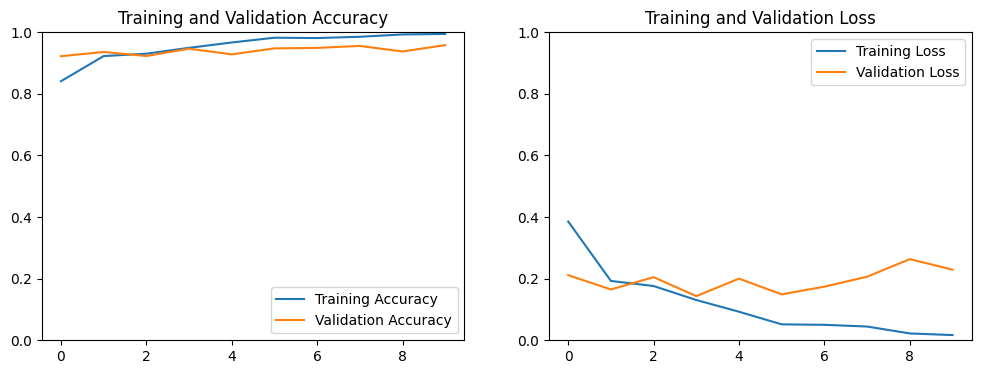

OVERFITTING!
(Blue) hits 100%, but the test Accuracy (Orange) is stuck at 90%.


In [43]:
EPOCHS = 10
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylim(bottom=0, top=1.0)

plt.show()

print("OVERFITTING!")
print("(Blue) hits 100%, but the test Accuracy (Orange) is stuck at 90%.")

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Reset generator to ensure order matches
val_generator.reset()

# Predict probabilities
predictions = model.predict(val_generator, verbose=1)

# Convert probabilities to class labels (0, 1, 2)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Generate Report
print("\n--- Classification Report ---")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Generate Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

94/94 ━━━━━━━━━━━━━━━━━━━━ 29s 310ms/step

--- Classification Report ---
                         precision    recall  f1-score   support

         adenocarcinoma       0.25      0.01      0.03      1000
                 benign       0.34      1.00      0.51      1000
squamous_cell_carcinoma       0.00      0.00      0.00      1000

               accuracy                           0.34      3000
              macro avg       0.20      0.34      0.18      3000
           weighted avg       0.20      0.34      0.18      3000



C:\Users\youss\OneDrive\Desktop\AI\Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\youss\OneDrive\Desktop\AI\Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\youss\OneDrive\Desktop\AI\Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

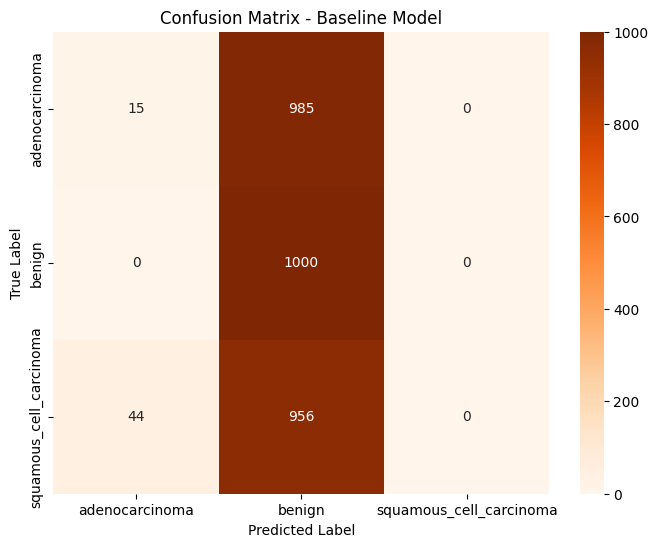

The model predicts 'Benign' for almost everything in the validation set.


In [38]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Baseline Model')
plt.show()

print("The model predicts 'Benign' for almost everything in the validation set.")

In [ ]:
## Conclusion for Version 1.0 (Baseline)
**Observation:**
The baseline model demonstrates signs of **overfitting**. While training accuracy increased, validation accuracy plateaued (or diverged). This indicates the model is memorizing the limited training samples rather than generalizing features.

**Next Steps (Phase 2):**
To improve generalization and robustness:
1.  **Data Augmentation:** We will implement `ImageDataGenerator` with rotation, zooming, and shearing to artificially expand the dataset diversity.
2.  **Regularization:** We may consider adding Dropout layers if augmentation alone is insufficient.

**Proceed to `model-augmented-v1.1.ipynb` for the improved implementation.**

In [50]:
IMG_HEIGHT = 128
IMG_WIDTH = 128

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 20% for test, 80% for train
)

print("Loading Training Data:")
train_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=42,
    shuffle=True
)

print("\nLoading Validation Data:")
val_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=42,
    shuffle=False
)

print(f"\nClass Indices: {train_generator.class_indices}")

Loading Training Data:
Found 12000 images belonging to 3 classes.

Loading Validation Data:
Found 3000 images belonging to 3 classes.

Class Indices: {'adenocarcinoma': 0, 'benign': 1, 'squamous_cell_carcinoma': 2}


In [51]:
# ATTEMPT 2 (Half THE NUMBER OF EPOCHS and half THE INPUT IMAGE RESOLUTION!!!).......

model2 = Sequential([
    # Input Layer
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),  # New: 128x128 instead of 256x256
    
    # Layer 1
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    # Layer 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    # Layer 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    
    # Output Layer (3 neurons for 3 classes, Softmax for probability distribution)
    Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,288,067 (16.36 MB)

 Trainable params: 4,288,067 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model2.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    verbose=1
)

Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 218s 577ms/step - accuracy: 0.8369 - loss: 0.3849 - val_accuracy: 0.9127 - val_loss: 0.2269
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 130s 347ms/step - accuracy: 0.9129 - loss: 0.2205 - val_accuracy: 0.9287 - val_loss: 0.1760
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 127s 339ms/step - accuracy: 0.9371 - loss: 0.1593 - val_accuracy: 0.9400 - val_loss: 0.1419
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 130s 347ms/step - accuracy: 0.9521 - loss: 0.1247 - val_accuracy: 0.9127 - val_loss: 0.2187
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 125s 334ms/step - accuracy: 0.9663 - loss: 0.0878 - val_accuracy: 0.9570 - val_loss: 0.1201


5


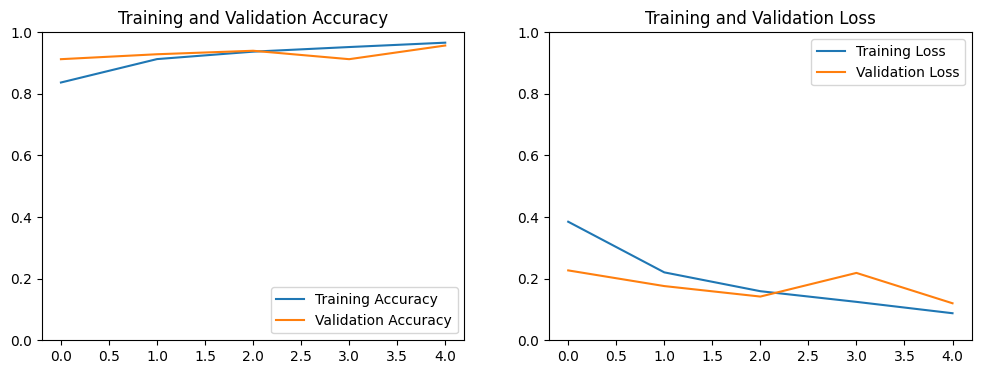

In [60]:
EPOCHS = 5
print(EPOCHS)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylim(bottom=0, top=1.0)

plt.show()

In [56]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Reset generator to ensure order matches
val_generator.reset()

# Predict probabilities
predictions = model2.predict(val_generator, verbose=1)

# Convert probabilities to class labels (0, 1, 2)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Generate Report
print("\n--- Classification Report ---")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Generate Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 177ms/step

--- Classification Report ---
                         precision    recall  f1-score   support

         adenocarcinoma       0.92      0.95      0.94      1000
                 benign       0.99      1.00      1.00      1000
squamous_cell_carcinoma       0.96      0.92      0.94      1000

               accuracy                           0.96      3000
              macro avg       0.96      0.96      0.96      3000
           weighted avg       0.96      0.96      0.96      3000



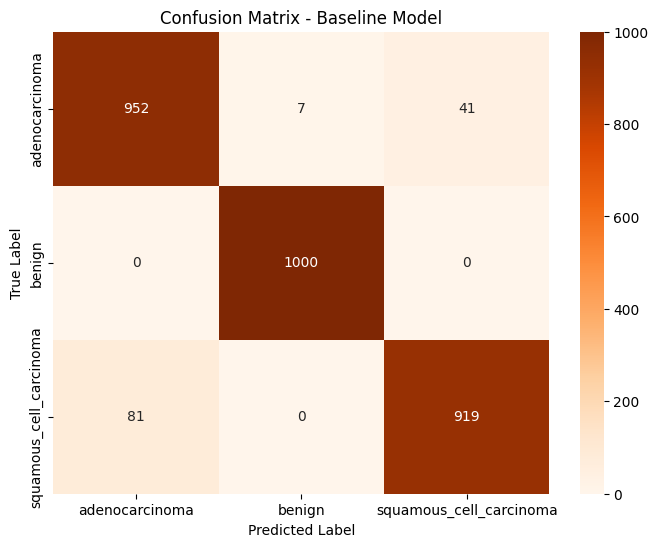

In [58]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Baseline Model')
plt.show()